# Capstone Project: Create a Customer Segmentation Report for Arvato Financial Services

In this project, you will analyze demographics data for customers of a mail-order sales company in Germany, comparing it against demographics information for the general population. You'll use unsupervised learning techniques to perform customer segmentation, identifying the parts of the population that best describe the core customer base of the company. Then, you'll apply what you've learned on a third dataset with demographics information for targets of a marketing campaign for the company, and use a model to predict which individuals are most likely to convert into becoming customers for the company. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

If you completed the first term of this program, you will be familiar with the first part of this project, from the unsupervised learning project. The versions of those two datasets used in this project will include many more features and has not been pre-cleaned. You are also free to choose whatever approach you'd like to analyzing the data rather than follow pre-determined steps. In your work on this project, make sure that you carefully document your steps and decisions, since your main deliverable for this project will be a blog post reporting your findings.

# Table of contents

A. Import needed packages

B. Define custom functions that are used in the Notebook 

   0.Inspect the dataset
*   0.1 Load the data
*   0.2 Inspect the datasets
*   0.3 Develop Feature Engineering
*   0.4 Feature Eng. Pipeline

1. Customer Segmentation Report 
* 1.1  PCA as Preperation
* 1.2  Perfrom Clustering
* 1.3  Result interpretation

2. Supervised learning Model
* 2.1 Load and investigate data
* 2.2 Build ML-Pipeline to thest diffrent algorithms
* 2.3 Optimize selected model

3. Kaggle Competition
* 3.1 Score data
* 3.2 Create export for Kaggle 



# A) Import needed packages

In [515]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# import missingno as msno


# ml

from scipy import stats

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

from imblearn.pipeline import Pipeline 
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,StratifiedKFold,RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold, learning_curve
from sklearn.metrics import accuracy_score, roc_auc_score
import xgboost as xgb
#store models
import pickle
# magic word for producing visualizations in notebook
%matplotlib inline

# B) Load custom functions

In [57]:
# Custom Functions for data preprocessing

def inspect_missings_column(df, bins = 10, plot = True):
    
    '''
   This function investigates the missings columnwise the dataset based on columns and plots some inforamtion
   
   Input:  df (df)- a dataframe that holds the data to be analyzid
          int (bins) - a nuber that indicats in how many bins the data should be subdivided for the analysis 
   
    '''

    for i in np.arange(0,100,bins):
        num_missings = (df.isnull().sum(axis=0)/df.shape[0] >= i/100).sum()
        percentage = round((num_missings / df.shape[1])*100,0)
        
        print('There are {} columns that have {}% or more missings. That are {}% of all columns.'.format(num_missings,i,percentage))
      
    if plot:
        #plotting the top 50 columsn with the most missing values 
        df_missing_info = df.isna().mean().sort_values(ascending = False)
        ax = df.isna().sum().sort_values(ascending=False).head(50).plot(kind='bar', figsize=(20,5), title='Missing Vlaues proportion for top 50 attirbutes')
        ax.set_xlabel("Column name")
        ax.set_ylabel("Share of missing values %")

        #plotting a distribution of missing coliumns
        fig, ax = plt.subplots(figsize= (20,5))
        fig.suptitle('Disribution of missing values of the dataset')
        sns.distplot(df_missing_info, bins = 100, color = 'r' )  
    else: print('Plots are disabeld.')


def inspect_missings_row(df, bins = 10, plot = True):
    
    '''
    Investigates and plots inforamtion about the missings in the rows. 
    INPUT:
    df (df) - Data set that is tested on missings per row and plots some inforamtion. 
    int (bins)- Number of bins that for the data can be grouped into. 
    '''
    
    
    print('Looking at the given dataset with a number of bins of  {} '.format(bins))
    
    missings_list = []
    
    for i in range(10, 110, bins):
        missings = df[df.isnull().mean(axis=1).values > i/100].shape[0]
        missings_list.append(missings)
        
        
        print('{} of all rows have {} missings or less, that are {}%. '.format(missings, i, round(missings/df.shape[0]*100)))
    if plot:
        
        # Plot distribution of missing values
        fig, ax = plt.subplots(figsize= (20,5))
        fig.suptitle('Disribution of missing values of the dataset')
        sns.distplot((df.isna().sum(axis=1) / df.shape[])  , color = 'r' ) 
    else: print('Plots are disabled.')
    
    

def change_unknown_to_nan(df):
    '''
    This function replaces all the values that are labled as unknown in the refernence excel file as null.
    INPUT: 
       df (df)- dataframe as input.
    OUTPUT:
        df(nan_df)- dataframe with unknown data labeld as NaNs.
    '''
    
    print('===============Changing the Unkown Data to NaNs======================')
    #load in the values from the dias excel 
    dias_values = pd.read_excel("DIAS Attributes - Values 2017.xlsx", header=1)
    dias_values = dias_values.fillna(method='ffill')
    dias_values = dias_values.replace({"CAMEO_DEUINTL_2015":"CAMEO_INTL_2015", "SOHO_FLAG":"SOHO_KZ", "D19_BUCH":"D19_BUCH_CD"})
    dias_values['Attribute'] = dias_values['Attribute'].map(lambda x: x.replace("_RZ", ""))

    # serch for the phrases in the "Meaning" Column for which values that shall be replaced as nan 
    nan_values = dias_values[(dias_values['Meaning'].str.contains('unknown')) | \
                             (dias_values['Meaning'].str.contains('no transaction known')) | \
                             (dias_values['Meaning'].str.contains('no main age detectable')) | \
                             (dias_values['Meaning'].str.contains('no transactions known'))]
    
    
    nan_ref = nan_values[['Attribute','Value']]

    nan_doku_dict = nan_ref.set_index('Attribute')['Value'].to_dict()



    for k,v in nan_doku_dict.items():
        if isinstance(v, str):
            v_new = {int(v): np.nan for v in v.split(",")}
            nan_doku_dict[k] = v_new
        else:
            v_new = {v : np.nan}
            nan_doku_dict[k] = v_new



    nan_df = df.replace(nan_doku_dict)
    
    #Edit some columns manually 
    nan_df['CAMEO_DEU_2015'].replace({'X': np.nan, 'XX':np.nan},inplace = True)
    nan_df['CAMEO_INTL_2015'].replace({'X': np.nan, 'XX':np.nan},inplace = True)
    nan_df['CAMEO_DEUG_2015'].replace({'X': np.nan, 'XX':np.nan},inplace = True)

    print('=====================================================================')

    return nan_df



def rem_nas(df, thresh_col = 0.5, thresh_row = 0.8):
    '''
    
    This function removes columns and rows that exeed a cirtain threshold of NaNs. 
    
    Input: df- The datframe for wich columns and rows should be removed 
    
    Output: df (df_clean)- A dataframe with reduced columns and rows based on the missing thresholds. 
    '''
    
    print('============Remiving Columns and Rows with to many NaNs==============')
    
    df_col =df.copy()
    
    print('---------Remove columns with more than {}% missings------------'.format(round(thresh_col*100)))
    print('The shape of the old dataframe:',df_col.shape)
    df_col = df_col.dropna(axis = 1 , thresh = df_col.shape[0]*(1 - thresh_col))
    print('The shape of the new dataframe:' ,df_col.shape)
    print('{} columns have been removed from the dataframe.'.format(df.shape[1]-df_col.shape[1]))

    print('----------------------------------------------------------------')
    
    print('---------Remove rows with more than {}% missings------------'.format(round(thresh_row*100)))
    print('The shape of the old dataframe:',df_col.shape)
    
    df_clean = df_col.dropna(axis = 0 , thresh = df_col.shape[1]*(1-thresh_row))
    print('The shape of the new dataframe:' ,df_clean.shape)
    print('{} rows have been removed from the dataframe.'.format(df_col.shape[0]-df_clean.shape[0]))
   
    return df_clean

    print('=====================================================================')



def impute_missings(df):
    
    
    '''
    This function imputes the missing values using differnt strategies that have been derived from the data inspection. 
    
    Input: 
        df (df)- Dataframe that for wich missing imputation should be applied.
        
    Output:
        df (df_imp)- Dataframe wich missings are imputed. 
    
    
    '''
    
    print('====================Data Imputation================================')

    
    # Check for each feature from the description file wich imputing strategy seams reasonable 
    df_imp = df.copy()
    
    
    
    unknown_10 = ['D19_BANKEN_DATUM','D19_BANKEN_OFFLINE_DATUM','D19_BANKEN_ONLINE_DATUM','D19_GESAMT_DATUM','D19_GESAMT_OFFLINE_DATUM','D19_GESAMT_ONLINE_DATUM' \
                  ,'D19_TELKO_DATUM','D19_TELKO_OFFLINE_DATUM','D19_TELKO_ONLINE_DATUM','D19_VERSAND_DATUM','D19_VERSAND_OFFLINE_DATUM','D19_VERSAND_ONLINE_DATUM']
    
    for col in unknown_10:
        try:
            df_imp[col].fillna(10,inplace = True)
        except: print('Col',col,'no in the df anymore.')
    
    print('Imputing 10er Values is done.')

    
    
    unknown_9 = ['KBA05_CCM1','ANREDE_KZ','KBA05_FRAU','KBA05_ALTER1','KBA05_ALTER2','KBA05_ALTER3','KBA05_ALTER4','KBA05_ANHANG']
    
    for col in unknown_9:
        try:
            df_imp[col].fillna(9,inplace = True)
        except: print('Col',col,'no in the df anymore.')
    print('Imputing 9er Values is done.')

    
    
    median = ['ANZ_HAUSHALTE_AKTIV','ANZ_HH_TITEL','ANZ_PERSONEN','GEBURTSJAHR']
    
    for col in median:
        try:
            df_imp[col].fillna(df_imp[col].median(),inplace = True)
        except: print('Col',col,'no in the df anymore.')

    print('Imputing Mean Values is done. ')

    
    most_frequent = ['BALLRAUM','CAMEO_DEUG_2015','CAMEO_DEU_2015','CJT_GESAMTTYP','D19_KONSUMTYP', 'EINGEFUEGT_AM','D19_LETZTER_KAUF_BRANCHE']
    
    for col in most_frequent:
        try:
            df_imp[col].fillna(list(df_imp[col].value_counts().index)[0],inplace = True)
        except: print('Col',col,'no in the df anymore.')

    print('Imputing most frequent values is done.')
                
    #Impute the rest with the simple imputer uning a constant vlaue 

    for col in df_imp.columns:
        df_imp[col].fillna(0,inplace=True)
    print('The rest of the columns are imputed with a zero. ')
    
    print('=====================================================================')
    
    return df_imp


def encode_data (df, categories = None):
    
    '''
    This fnction encodes the dataset. Default is that all "object" columns should be processed. 
    Optionaly it can take an array of manually selectd categorical colimns. 
    
    Input:
        df (df)- Dataframe that is to be endoded. 
    Output:
        df(enc_df)- Encoded dataframe. 
    
    '''
    
    
    enc_df = df.copy()
    enc_df.drop(['EINGEFUEGT_AM'], axis = 1,inplace = True)
    
    if categories == None: categories = df.select_dtypes(include='object').columns
        
    print(categories)
    
    for v in categories:
        try:
            enc_df = pd.concat([enc_df.drop(v, axis=1), pd.get_dummies(enc_df[v], prefix=v, prefix_sep='_', drop_first=True)], axis=1 )
            print('Encode:', v)
        except: print('Column ', v, ' not found.')
   
    return enc_df
    

## Part 0: Get to Know the Data

There are four data files associated with this project:

- `Udacity_AZDIAS_052018.csv`: Demographics data for the general population of Germany; 891 211 persons (rows) x 366 features (columns).
- `Udacity_CUSTOMERS_052018.csv`: Demographics data for customers of a mail-order company; 191 652 persons (rows) x 369 features (columns).
- `Udacity_MAILOUT_052018_TRAIN.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 982 persons (rows) x 367 (columns).
- `Udacity_MAILOUT_052018_TEST.csv`: Demographics data for individuals who were targets of a marketing campaign; 42 833 persons (rows) x 366 (columns).

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. Use the information from the first two files to figure out how customers ("CUSTOMERS") are similar to or differ from the general population at large ("AZDIAS"), then use your analysis to make predictions on the other two files ("MAILOUT"), predicting which recipients are most likely to become a customer for the mail-order company.

The "CUSTOMERS" file contains three extra columns ('CUSTOMER_GROUP', 'ONLINE_PURCHASE', and 'PRODUCT_GROUP'), which provide broad information about the customers depicted in the file. The original "MAILOUT" file included one additional column, "RESPONSE", which indicated whether or not each recipient became a customer of the company. For the "TRAIN" subset, this column has been retained, but in the "TEST" subset it has been removed; it is against that withheld column that your final predictions will be assessed in the Kaggle competition.

Otherwise, all of the remaining columns are the same between the three data files. For more information about the columns depicted in the files, you can refer to two Excel spreadsheets provided in the workspace. [One of them](./DIAS Information Levels - Attributes 2017.xlsx) is a top-level list of attributes and descriptions, organized by informational category. [The other](./DIAS Attributes - Values 2017.xlsx) is a detailed mapping of data values for each feature in alphabetical order.

In the below cell, we've provided some initial code to load in the first two datasets. Note for all of the `.csv` data files in this project that they're semicolon (`;`) delimited, so an additional argument in the [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call has been included to read in the data properly. Also, considering the size of the datasets, it may take some time for them to load completely.

You'll notice when the data is loaded in that a warning message will immediately pop up. Before you really start digging into the modeling and analysis, you're going to need to perform some cleaning. Take some time to browse the structure of the data and look over the informational spreadsheets to understand the data values. Make some decisions on which features to keep, which features to drop, and if any revisions need to be made on data formats. It'll be a good idea to create a function with pre-processing steps, since you'll need to clean all of the datasets before you work with them.

### 0.1 Load the Dataa

In [3]:
%%time
# load in the data
dtypes = {'CAMEO_INTL_2015': object , 'CAMEO_DEUG_2015': object} # make sure the data is read in without mixed valeus errpr  
azdias = pd.read_csv('data/Udacity_AZDIAS_052018.csv', sep=';', dtype=dtypes)
customers = pd.read_csv('data/Udacity_CUSTOMERS_052018.csv', sep=';',dtype=dtypes)

CPU times: user 18.9 s, sys: 2.35 s, total: 21.3 s
Wall time: 21.3 s


### 0.2) Inspect the datasets

#### AZDIAS Dataset

In [4]:
print("The AZDIASD Dataset has {} rows.".format(azdias.shape[0]))
print("The AZDIASD Dataset has {} columns.".format(azdias.shape[1]))

The AZDIASD Dataset has 891221 rows.
The AZDIASD Dataset has 366 columns.


In [5]:
#looging at the azdias df
azdias.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,910215,-1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3,1,2
1,910220,-1,9.0,0.0,NaN,NaN,NaN,NaN,21.0,11.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
2,910225,-1,9.0,17.0,NaN,NaN,NaN,NaN,17.0,10.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
3,910226,2,1.0,13.0,NaN,NaN,NaN,NaN,13.0,1.0,...,0.0,7.0,10.0,11.0,NaN,9.0,7.0,3,2,4
4,910241,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,3.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3


In [6]:
azdias.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,891221.0,637263.000000,257273.486465,191653.0,414458.0,637263.0,860068.0,1082873.0
AGER_TYP,891221.0,-0.358435,1.198724,-1.0,-1.0,-1.0,-1.0,3.0
AKT_DAT_KL,817722.0,4.421928,3.638805,1.0,1.0,3.0,9.0,9.0
ALTER_HH,817722.0,10.864126,7.639683,0.0,0.0,13.0,17.0,21.0
ALTER_KIND1,81058.0,11.745392,4.097660,2.0,8.0,12.0,15.0,18.0
...,...,...,...,...,...,...,...,...
WOHNDAUER_2008,817722.0,7.908791,1.923137,1.0,8.0,9.0,9.0,9.0
WOHNLAGE,798073.0,4.052836,1.949539,0.0,3.0,3.0,5.0,8.0
ZABEOTYP,891221.0,3.362438,1.352704,1.0,3.0,3.0,4.0,6.0
ANREDE_KZ,891221.0,1.522098,0.499512,1.0,1.0,2.0,2.0,2.0


In [7]:
# what are the occurring datatyps in the azdias dataset
azdias.dtypes.value_counts()

float64    267
int64       93
object       6
dtype: int64

Most of the colums are numeric. Just six coliumns are from the type object. 
However the mixed columns appear to be numerical at a first glance.

In [8]:
azdias.select_dtypes(include = 'object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
0,NaN,NaN,NaN,NaN,NaN,NaN
1,8A,8,51,NaN,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


In [9]:
# ivestigating the mixed columns that produce an error if not read in as an object
azdias['CAMEO_DEUG_2015'].unique()

array([nan, '8', '4', '2', '6', '1', '9', '5', '7', '3', 'X'],
      dtype=object)

In [27]:
azdias['CAMEO_INTL_2015'].unique()

array([nan, '51', '24', '12', '43', '54', '22', '14', '13', '15', '33',
       '41', '34', '55', '25', '23', '31', '52', '35', '45', '44', '32',
       'XX'], dtype=object)

The problem with the both CAMEO_DEUG_2015 and CAMEO_DEUG_2015 was that they contained an X what is assumed to be a unknown.
This sould be later convertet to as a NaN - than the variabels are numerical. 

#### Data description file 


In [11]:
#load in the description file and process it so that it can be used for the analysis
desc_azdias = pd.read_excel('DIAS Attributes - Values 2017.xlsx', skiprows=1).drop('Unnamed: 0', axis=1)
desc_azdias.fillna(method='ffill', inplace=True) 

In [12]:
desc_azdias[desc_azdias['Meaning'] == 'unknown']['Value'].value_counts()


-1       138
-1, 9     75
-1, 0     16
0          2
-1         1
Name: Value, dtype: int64

The datasets seem to have a some data labled as unknown. They are often coded as -1 or 9.
It would make sense to code them laten in the processing as NaNs. 

In [13]:
azdias.columns

Index(['LNR', 'AGER_TYP', 'AKT_DAT_KL', 'ALTER_HH', 'ALTER_KIND1',
       'ALTER_KIND2', 'ALTER_KIND3', 'ALTER_KIND4', 'ALTERSKATEGORIE_FEIN',
       'ANZ_HAUSHALTE_AKTIV',
       ...
       'VHN', 'VK_DHT4A', 'VK_DISTANZ', 'VK_ZG11', 'W_KEIT_KIND_HH',
       'WOHNDAUER_2008', 'WOHNLAGE', 'ZABEOTYP', 'ANREDE_KZ',
       'ALTERSKATEGORIE_GROB'],
      dtype='object', length=366)

#### Cusomers Dataset


In [14]:
print("The Customers Dataset has {} rows.".format(customers.shape[0]))
print("The Customers Dataset has {} columns.".format(customers.shape[1]))

The Customers Dataset has 191652 rows.
The Customers Dataset has 369 columns.


In [15]:
#looging at the customers df
customers.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTER_KIND1,ALTER_KIND2,ALTER_KIND3,ALTER_KIND4,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,...,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,PRODUCT_GROUP,CUSTOMER_GROUP,ONLINE_PURCHASE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,9626,2,1.0,10.0,NaN,NaN,NaN,NaN,10.0,1.0,...,2.0,6.0,9.0,7.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,1,4
1,9628,-1,9.0,11.0,NaN,NaN,NaN,NaN,NaN,NaN,...,3.0,0.0,9.0,NaN,3,FOOD,SINGLE_BUYER,0,1,4
2,143872,-1,1.0,6.0,NaN,NaN,NaN,NaN,0.0,1.0,...,11.0,6.0,9.0,2.0,3,COSMETIC_AND_FOOD,MULTI_BUYER,0,2,4
3,143873,1,1.0,8.0,NaN,NaN,NaN,NaN,8.0,0.0,...,2.0,NaN,9.0,7.0,1,COSMETIC,MULTI_BUYER,0,1,4
4,143874,-1,1.0,20.0,NaN,NaN,NaN,NaN,14.0,7.0,...,4.0,2.0,9.0,3.0,1,FOOD,MULTI_BUYER,0,1,3


In [16]:
#get sumarizing descriptive statistics of the customers df
customers.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
LNR,191652.0,95826.500000,55325.311233,1.0,47913.75,95826.5,143739.25,191652.0
AGER_TYP,191652.0,0.344359,1.391672,-1.0,-1.00,0.0,2.00,3.0
AKT_DAT_KL,145056.0,1.747525,1.966334,1.0,1.00,1.0,1.00,9.0
ALTER_HH,145056.0,11.352009,6.275026,0.0,8.00,11.0,16.00,21.0
ALTER_KIND1,11766.0,12.337243,4.006050,2.0,9.00,13.0,16.00,18.0
...,...,...,...,...,...,...,...,...
WOHNLAGE,141725.0,3.723133,2.095540,0.0,2.00,3.0,5.00,8.0
ZABEOTYP,191652.0,2.576806,1.168486,1.0,1.00,3.0,3.00,6.0
ONLINE_PURCHASE,191652.0,0.090247,0.286536,0.0,0.00,0.0,0.00,1.0
ANREDE_KZ,191652.0,1.376432,0.484492,1.0,1.00,1.0,2.00,2.0


In [17]:
# what data types ocour how often in the df
customers.dtypes.value_counts()

float64    267
int64       94
object       8
dtype: int64

Comparing Customers to the Azdias data

In [18]:
# Comparing the columns in azdias and customer
print('Number of columns in azdias:   ', azdias.shape[1])
print('Number of columns in customers:', customers.shape[1])
cols_cust_only = list(set(customers.columns).difference(set(azdias.columns)))
print('Columns in customer that do  not exists in azdias: ', cols_cust_only)

Number of columns in azdias:    366
Number of columns in customers: 369
Columns in customer that do  not exists in azdias:  ['ONLINE_PURCHASE', 'PRODUCT_GROUP', 'CUSTOMER_GROUP']


The Custoemrs datset has the same features like the azdias dataset plus three additional features.
Since these are all purchase related features it makes sense, that they donot exist in the dataframe of the non-customers.
Since they do not provide any value for comparisom they should be droped later in the processing. 

#### Missing values 

##### Azidas Data - Missings in Columns

There are 366 columns that have 0% or more missings. That are 100.0% of all columns.
There are 237 columns that have 10% or more missings. That are 65.0% of all columns.
There are 16 columns that have 20% or more missings. That are 4.0% of all columns.
There are 6 columns that have 30% or more missings. That are 2.0% of all columns.
There are 6 columns that have 40% or more missings. That are 2.0% of all columns.
There are 6 columns that have 50% or more missings. That are 2.0% of all columns.
There are 6 columns that have 60% or more missings. That are 2.0% of all columns.
There are 5 columns that have 70% or more missings. That are 1.0% of all columns.
There are 4 columns that have 80% or more missings. That are 1.0% of all columns.
There are 4 columns that have 90% or more missings. That are 1.0% of all columns.


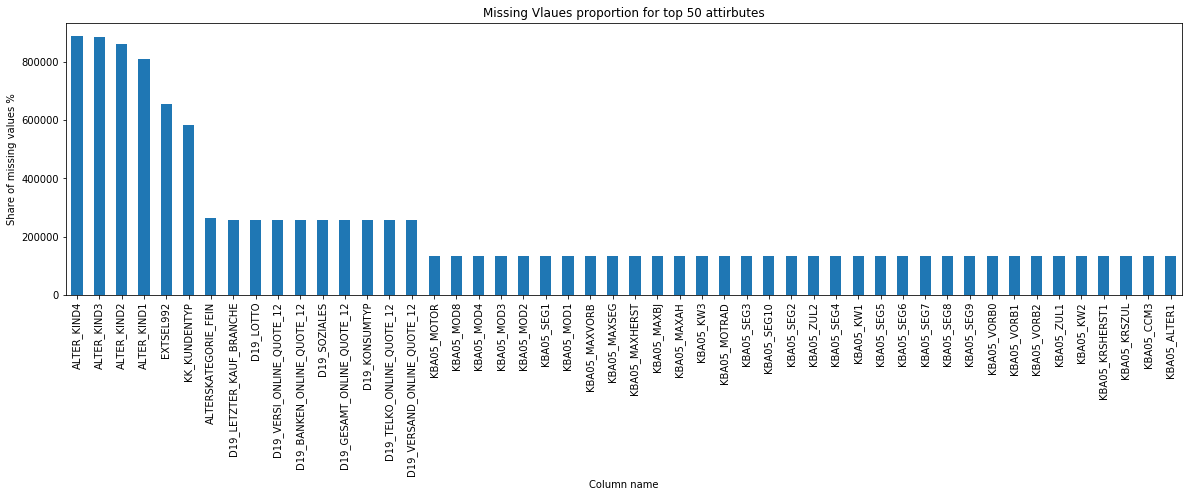

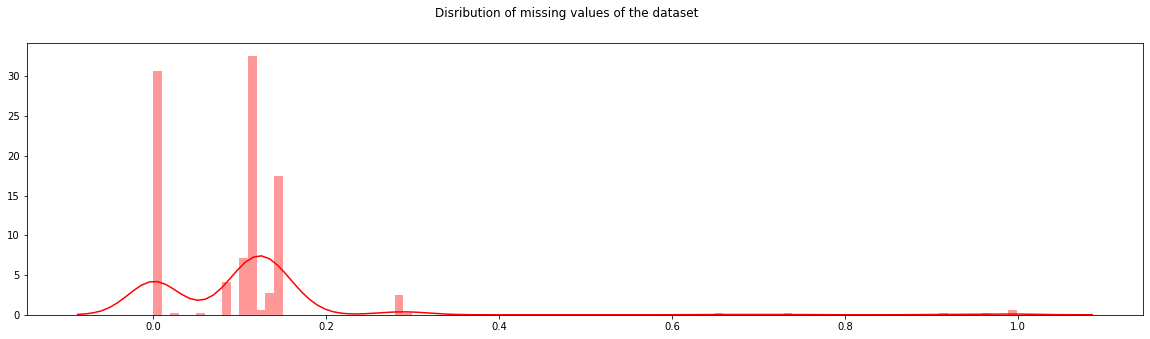

In [29]:
inspect_missings_column(azdias)

##### Customers Missing in Columns 

In [ ]:
inspect_missings_column(customers)

There are 6 columns in the customers and azidas datafram that have more than 30% of missings. 
Thereby this seems to be a good threshold to drop all columns that have more than 30% of missings. 

##### AZDIAS Missing in rows

Looking at the given dataset with a number of bins of  10 
140484 of all rows have 10 missings or less, that are 16%. 
118087 of all rows have 20 missings or less, that are 13%. 
105805 of all rows have 30 missings or less, that are 12%. 
99264 of all rows have 40 missings or less, that are 11%. 
99231 of all rows have 50 missings or less, that are 11%. 
93168 of all rows have 60 missings or less, that are 10%. 
17 of all rows have 70 missings or less, that are 0%. 
0 of all rows have 80 missings or less, that are 0%. 
0 of all rows have 90 missings or less, that are 0%. 
0 of all rows have 100 missings or less, that are 0%. 


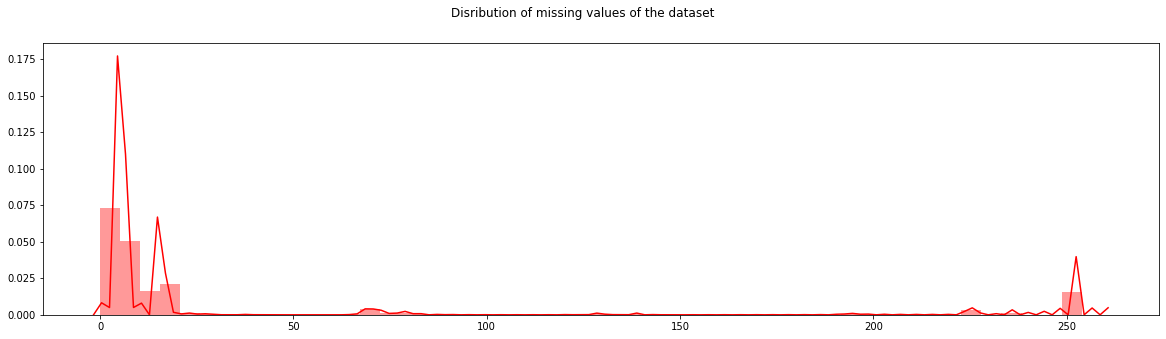

In [55]:
inspect_missings_row(azdias)

##### Custoemrs Missing in rows

Looking at the given dataset with a number of bins of  10 
56574 of all rows have 10 missings or less, that are 30%. 
52572 of all rows have 20 missings or less, that are 27%. 
51281 of all rows have 30 missings or less, that are 27%. 
50763 of all rows have 40 missings or less, that are 26%. 
50751 of all rows have 50 missings or less, that are 26%. 
49911 of all rows have 60 missings or less, that are 26%. 
3 of all rows have 70 missings or less, that are 0%. 
0 of all rows have 80 missings or less, that are 0%. 
0 of all rows have 90 missings or less, that are 0%. 
0 of all rows have 100 missings or less, that are 0%. 


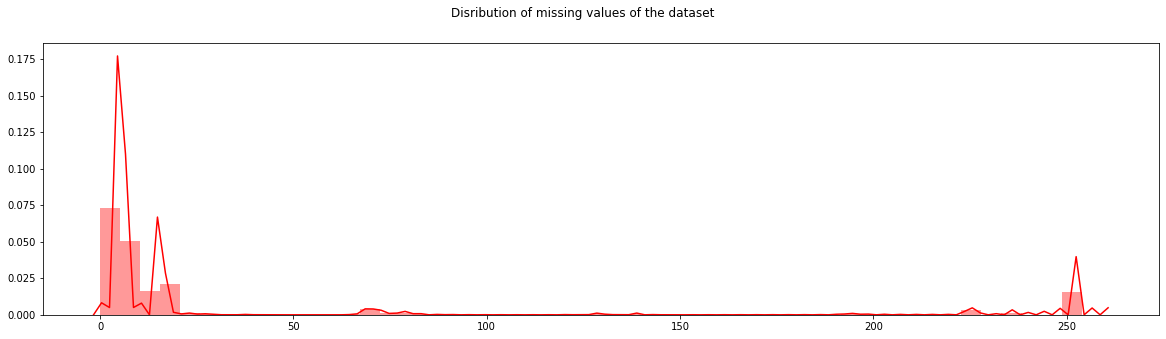

In [56]:
inspect_missings_row(customers)

In the azdasi there are olny 17 and in the customer dataset zero obeservations that have more than 70% of missings. 
However when we relabele the values as stated in the previous section the numbers could change. 

### 0.3 Develop feature engieering

#### Unknown Data Relableling

In [32]:
# convert all unknown values from the azdias df to nans 
azdias_rep = change_unknown_to_nan(azdias) 
# convert all unknown values from the customers df to nans 
customers_rep = change_unknown_to_nan(customers) 

===============Changing the Unkown Data to NaNs======================
===============Changing the Unkown Data to NaNs======================


Before handeling missings the data that is labeld as unkown is transformed to NaNs, since it does not hold any mor infroamtion than a missing.
Therefore the missings values are standadized. 


In [33]:
#check again for missings after relableing the "unkown data"

In [34]:
# first look at the columns 

There are 366 columns that have 0% or more missings. That are 100.0% of all columns.
There are 299 columns that have 10% or more missings. That are 82.0% of all columns.
There are 74 columns that have 20% or more missings. That are 20.0% of all columns.
There are 65 columns that have 30% or more missings. That are 18.0% of all columns.
There are 63 columns that have 40% or more missings. That are 17.0% of all columns.
There are 62 columns that have 50% or more missings. That are 17.0% of all columns.
There are 57 columns that have 60% or more missings. That are 16.0% of all columns.
There are 52 columns that have 70% or more missings. That are 14.0% of all columns.
There are 43 columns that have 80% or more missings. That are 12.0% of all columns.
There are 25 columns that have 90% or more missings. That are 7.0% of all columns.


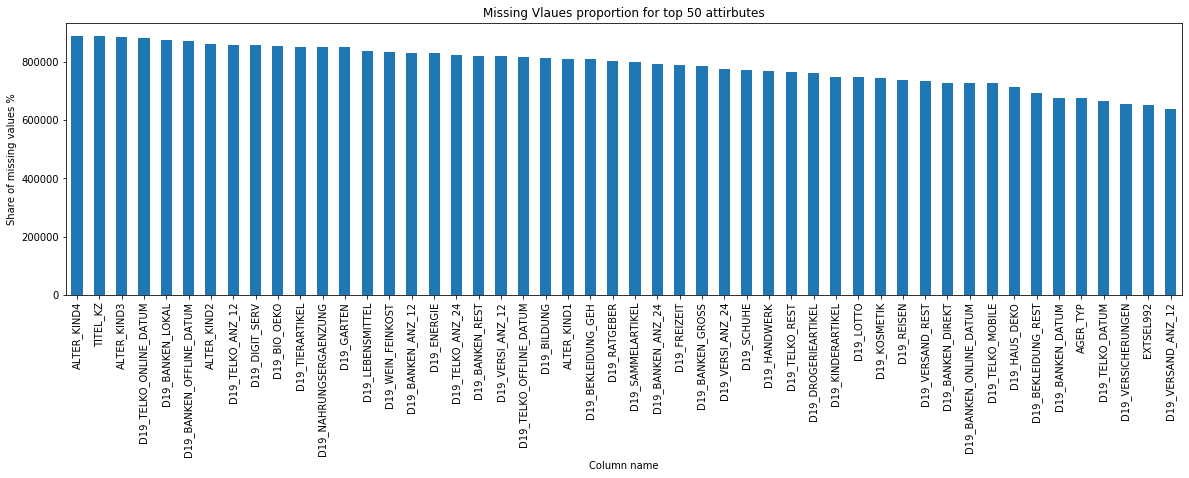

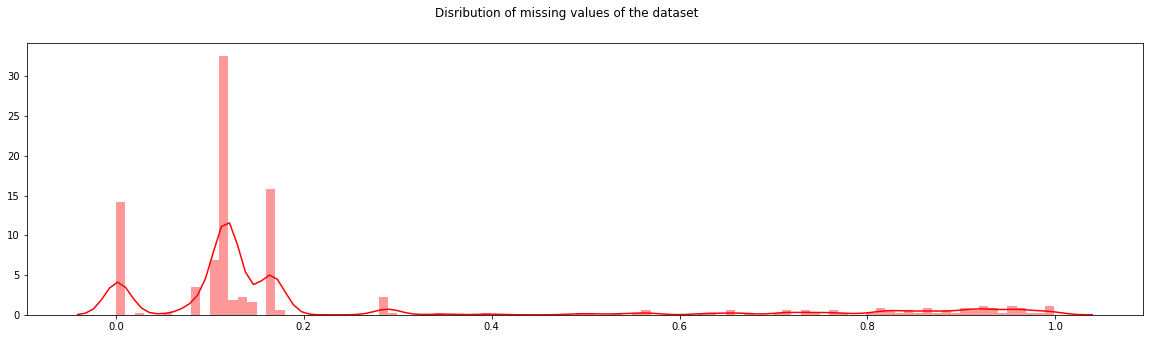

In [47]:
inspect_missings_column(azdias_rep,plot=True)

There are 369 columns that have 0% or more missings. That are 100.0% of all columns.
There are 313 columns that have 10% or more missings. That are 85.0% of all columns.
There are 313 columns that have 20% or more missings. That are 85.0% of all columns.
There are 67 columns that have 30% or more missings. That are 18.0% of all columns.
There are 61 columns that have 40% or more missings. That are 17.0% of all columns.
There are 56 columns that have 50% or more missings. That are 15.0% of all columns.
There are 49 columns that have 60% or more missings. That are 13.0% of all columns.
There are 46 columns that have 70% or more missings. That are 12.0% of all columns.
There are 37 columns that have 80% or more missings. That are 10.0% of all columns.
There are 22 columns that have 90% or more missings. That are 6.0% of all columns.


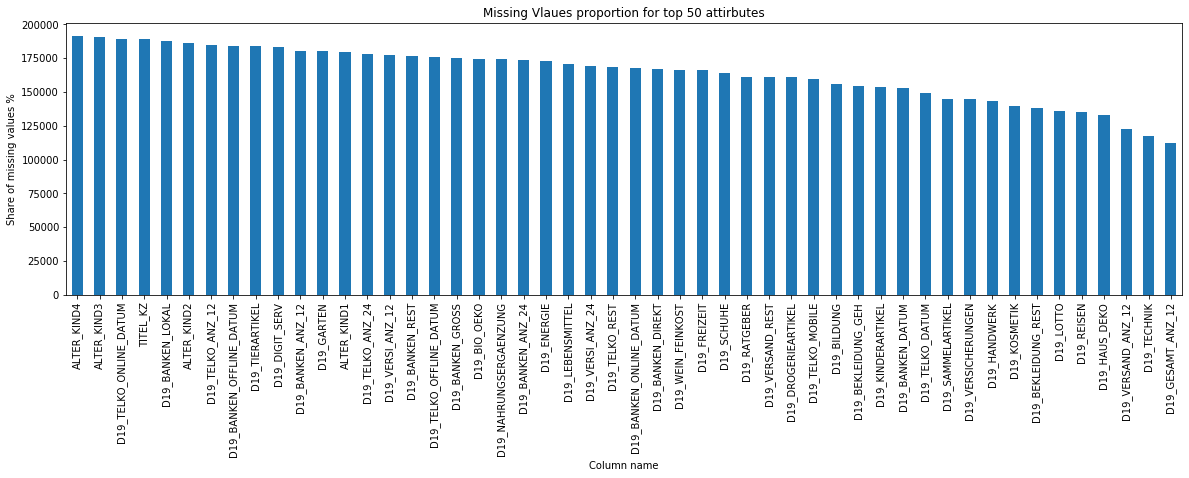

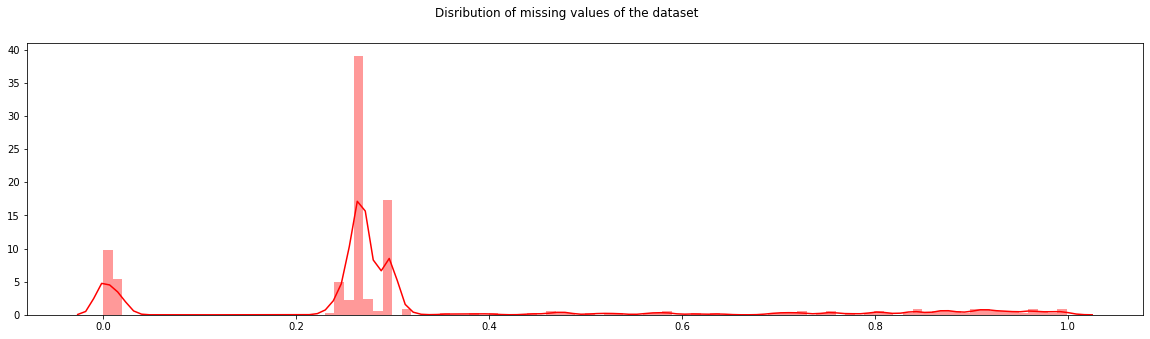

In [48]:
inspect_missings_column(customers_rep,plot=True)

Now 52 Columns in the AZDIAS and 46 in the CUSTUMERS dataset have more than 30% missings. 
In order not to drop to much data the dropping point will be set to 50%.
That means 62 columns (16%) and 56(15%) of the columns will be dropped. 

In [37]:
#Plotting the Row missings stats

Looking at the given dataset with a number of bins of  10 
817232 of all rows have 10 missings or less, that are 92%. 
217314 of all rows have 20 missings or less, that are 24%. 
139620 of all rows have 30 missings or less, that are 16%. 
106212 of all rows have 40 missings or less, that are 12%. 
103235 of all rows have 50 missings or less, that are 12%. 
99746 of all rows have 60 missings or less, that are 11%. 
92402 of all rows have 70 missings or less, that are 10%. 
76848 of all rows have 80 missings or less, that are 9%. 
0 of all rows have 90 missings or less, that are 0%. 
0 of all rows have 100 missings or less, that are 0%. 


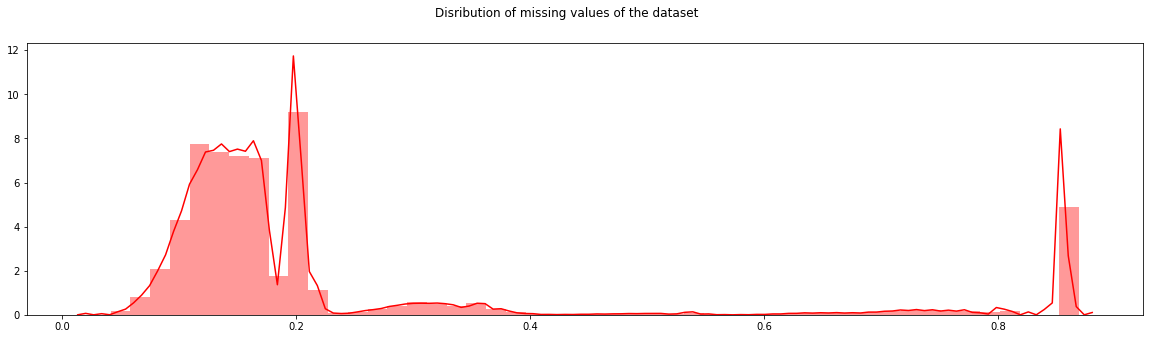

In [58]:
inspect_missings_row(azdias_rep,plot=False)

Looking at the given dataset with a number of bins of  10 
165976 of all rows have 10 missings or less, that are 87%. 
58608 of all rows have 20 missings or less, that are 31%. 
54588 of all rows have 30 missings or less, that are 28%. 
51287 of all rows have 40 missings or less, that are 27%. 
50866 of all rows have 50 missings or less, that are 27%. 
50732 of all rows have 60 missings or less, that are 26%. 
49151 of all rows have 70 missings or less, that are 26%. 
46622 of all rows have 80 missings or less, that are 24%. 
0 of all rows have 90 missings or less, that are 0%. 
0 of all rows have 100 missings or less, that are 0%. 


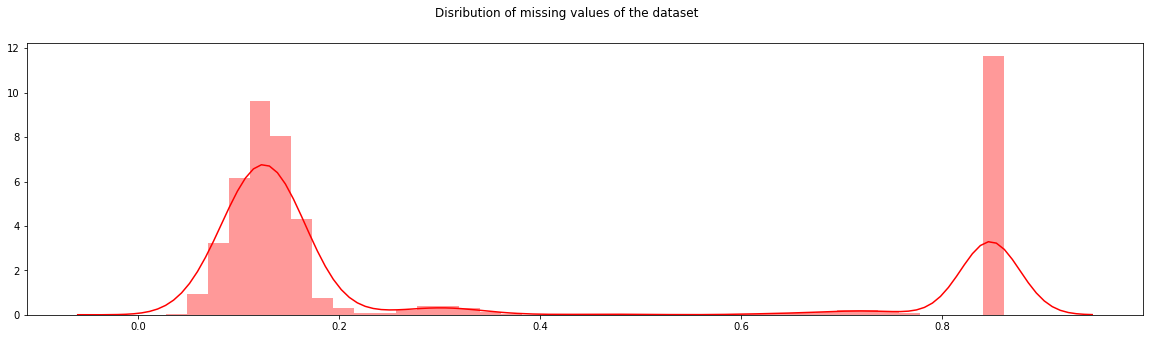

In [59]:
inspect_missings_row(customers_rep,plot=False)

By looking at the rows having 70% still seams to be a reasonable threshold. 
That means dropping 76848 (9%) from AZIDAS and 46622 (24%) of the observations from CUSTOMERS.

#### Droping Columns and Rows based on their missings

The first step of handeling missings is to look for columns and rows that have a so many missings that it would make snese to rather drop themm instead of imputing them.

In [60]:
azdias_nan = rem_nas(azdias_rep)

============Remiving Columns and Rows with to many NaNs==============
---------Remove columns with more than 50% missings------------
The shape of the old dataframe: (891221, 366)
The shape of the new dataframe: (891221, 304)
62 columns have been removed from the dataframe.
----------------------------------------------------------------
---------Remove rows with more than 80% missings------------
The shape of the old dataframe: (891221, 304)
The shape of the new dataframe: (817688, 304)
73533 rows have been removed from the dataframe.


#### Impute the rest of the missing values

The imputaion shpuld takte the variables type into account. 
The datasets mostly consitst of categorical but also ordinal and continus numerical features. 
For a lot of the features there exists an "neutral" element such as "none" or "no treansactions known" these are often either coded as a zero or ten. So the in the first part I will impute the nans of these features the this. 


In [61]:
az_imp = impute_missings(azdias_nan)

====================Data Imputation================================
Col D19_BANKEN_DATUM no in the df anymore.
Col D19_BANKEN_OFFLINE_DATUM no in the df anymore.
Col D19_BANKEN_ONLINE_DATUM no in the df anymore.
Col D19_GESAMT_OFFLINE_DATUM no in the df anymore.
Col D19_GESAMT_ONLINE_DATUM no in the df anymore.
Col D19_TELKO_DATUM no in the df anymore.
Col D19_TELKO_OFFLINE_DATUM no in the df anymore.
Col D19_TELKO_ONLINE_DATUM no in the df anymore.
Col D19_VERSAND_OFFLINE_DATUM no in the df anymore.
Col D19_VERSAND_ONLINE_DATUM no in the df anymore.
Imputing 10er Values is done.
Imputing 9er Values is done.
Imputing Mean Values is done. 
Imputing most frequent values is done.
The rest of the columns are imputed with a zero. 


In [62]:
#checking if missings left 
az_imp.isna().mean().sum()

0.0

In [63]:
# checking whichb colums are of thype object
az_imp.select_dtypes(include='object')

,CAMEO_DEU_2015,CAMEO_DEUG_2015,CAMEO_INTL_2015,D19_LETZTER_KAUF_BRANCHE,EINGEFUEGT_AM,OST_WEST_KZ
1,8A,8,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
2,4C,4,24,D19_UNBEKANNT,1992-02-12 00:00:00,W
3,2A,2,12,D19_UNBEKANNT,1997-04-21 00:00:00,W
4,6B,6,43,D19_SCHUHE,1992-02-12 00:00:00,W
5,8C,8,54,D19_ENERGIE,1992-02-12 00:00:00,W
...,...,...,...,...,...,...
891216,7A,7,41,D19_HAUS_DEKO,1992-02-10 00:00:00,W
891217,9D,9,51,D19_UNBEKANNT,1992-02-10 00:00:00,W
891218,4C,4,24,D19_BEKLEIDUNG_GEH,1992-02-10 00:00:00,W
891219,9D,9,51,D19_UNBEKANNT,1992-02-12 00:00:00,W


#### Encoding of the differnt Varibales

The remaining six columns must me encoded since they are one-hot encoded.
Here however it could be beneficial to investigate the data for even more catigorical data that are not labeld as such yet.
In this work is was assumed that most of the data is ordnial data and thereby must not be further encoded. 


In [64]:
#checking the cardinality before applying one-hot encoding
for c in az_imp.select_dtypes(include='object').columns:
    print(c,": ",len(az_imp[c].value_counts()))

CAMEO_DEU_2015 :  44
CAMEO_DEUG_2015 :  9
CAMEO_INTL_2015 :  22
D19_LETZTER_KAUF_BRANCHE :  35
EINGEFUEGT_AM :  5162
OST_WEST_KZ :  3


The check shows that the column 'EINGEFUEGT_AM' must not be one-hot-encoded, since it is a data column wich would explode the data. 
It can be either furher processed or dropped, wich i decided for. 

In [65]:
az_enc = encode_data(az_imp)

Index(['CAMEO_DEU_2015', 'CAMEO_DEUG_2015', 'CAMEO_INTL_2015',
       'D19_LETZTER_KAUF_BRANCHE', 'EINGEFUEGT_AM', 'OST_WEST_KZ'],
      dtype='object')
Encode: CAMEO_DEU_2015
Encode: CAMEO_DEUG_2015
Encode: CAMEO_INTL_2015
Encode: D19_LETZTER_KAUF_BRANCHE
Column  EINGEFUEGT_AM  not found.
Encode: OST_WEST_KZ


In [66]:
az_enc.shape

(817688, 406)

### 0.4) Fetaure Eng. Pipeline

Finally all the above steps are comined into a data preperation pipeline wich is used in the following. 

In [368]:
def data_load_and_prep(file_path, score_mode = False):
    '''
    This functions loads the csv files into python and provides all the transforamtion on the data that have been shown above.
    Finally it outputs a cleaned dataframe that can be used for machine learning algorithmes
    
    1.) The dataset is loaded into python 
    2.) Change the unknown values to nan values
    2.) Missings values are handeld by dropping some colums and rows 
    3.) Missing values are handeld by appropriate imputaiomn
    4.) Thte data is ecoded 
    
    '''
    
    
    # 1) Load the data into python
     
    dt = {'CAMEO_INTL_2015': object , 'CAMEO_DEUG_2015': object}
    df = pd.read_csv(file_path, sep=';', dtype=dtypes)
    
    #drop some columns that are not needed 
    dro = ['CUSTOMER_GROUP','ONLINE_PURCHASE','PRODUCT_GROUP']
    for c in dro:
        try:
            df.drop(c,axis=1, inplace = True)
            print('Drop ',c,' from customers dataset.')
        except:
            print('Column ',c,' was not in the df.')
                
    if score_mode==False: 
        df.drop(['LNR'],axis=1, inplace = True) 
    else: print('LNR is keept for scoring')
        
    # 2) Change all the values taht are labeld as unkowns in the description file to nan values
    df = change_unknown_to_nan(df)
    
    # 3) Drop colmuns and rows wich exceed a the threshold of 30% of missings
    if score_mode == True:
        tresh_row = 1
    else: tresh_row=0.8
        
    df = rem_nas(df,thresh_row = tresh_row)
    
    # 4) Impute the rest of the missings using appropirate strategies 
    df = impute_missings(df)
    
    # 5) Encode the objects to numericals 
    df_enc = encode_data(df)
    
    return df_enc 
    

In [68]:
# load an process the customers dataframe 
cu_enc = data_load_and_prep('data/Udacity_CUSTOMERS_052018.csv')

Drop  CUSTOMER_GROUP  from customers dataset.
Drop  ONLINE_PURCHASE  from customers dataset.
Drop  PRODUCT_GROUP  from customers dataset.
LNR Column is droped from the data.
===============Changing the Unkown Data to NaNs======================
============Remiving Columns and Rows with to many NaNs==============
---------Remove columns with more than 50% missings------------
The shape of the old dataframe: (191652, 365)
The shape of the new dataframe: (191652, 309)
56 columns have been removed from the dataframe.
----------------------------------------------------------------
---------Remove rows with more than 80% missings------------
The shape of the old dataframe: (191652, 309)
The shape of the new dataframe: (145036, 309)
46616 rows have been removed from the dataframe.
====================Data Imputation================================
Col D19_BANKEN_DATUM no in the df anymore.
Col D19_BANKEN_OFFLINE_DATUM no in the df anymore.
Col D19_BANKEN_ONLINE_DATUM no in the df anymore.
Co

In [69]:
cu_enc.shape

(145036, 411)

In [70]:
az_enc = data_load_and_prep('data/Udacity_AZDIAS_052018.csv')

Column  CUSTOMER_GROUP  was not in the df.
Column  ONLINE_PURCHASE  was not in the df.
Column  PRODUCT_GROUP  was not in the df.
LNR Column is droped from the data.
===============Changing the Unkown Data to NaNs======================
============Remiving Columns and Rows with to many NaNs==============
---------Remove columns with more than 50% missings------------
The shape of the old dataframe: (891221, 365)
The shape of the new dataframe: (891221, 303)
62 columns have been removed from the dataframe.
----------------------------------------------------------------
---------Remove rows with more than 80% missings------------
The shape of the old dataframe: (891221, 303)
The shape of the new dataframe: (817673, 303)
73548 rows have been removed from the dataframe.
====================Data Imputation================================
Col D19_BANKEN_DATUM no in the df anymore.
Col D19_BANKEN_OFFLINE_DATUM no in the df anymore.
Col D19_BANKEN_ONLINE_DATUM no in the df anymore.
Col D19_GES

In [78]:
az_enc.shape

(817673, 405)

## Part 1: Customer Segmentation Report

The main bulk of your analysis will come in this part of the project. Here, you should use unsupervised learning techniques to describe the relationship between the demographics of the company's existing customers and the general population of Germany. By the end of this part, you should be able to describe parts of the general population that are more likely to be part of the mail-order company's main customer base, and which parts of the general population are less so.

### 1.1 PCA as preperation 

Since there are still more than 400 columns in the datasets, PCA is conducted in order do lower the dimesnions of the datasets. This article served as a rough guidence. 

In [79]:
#find common columns in azdias and customwers 
comon_cols = np.intersect1d(cu_enc.columns, az_enc.columns )
drop_azdias = np.setdiff1d(az_enc.columns, comon_cols)
drop_customers = np.setdiff1d(cu_enc.columns, comon_cols)

az_enc.drop(drop_azdias,axis=1,inplace = True)
cu_enc.drop(drop_customers,axis=1,inplace=True)

In [80]:
az_enc.shape

(817673, 405)

In [81]:
cu_enc.shape

(145036, 405)

In [82]:
def learn_principal_components(df, percent):
    '''
    This method lerns a PCA based for a given df and a percentage. 
    
    Input:
        df- a data frame the pca should be applyed to 
        float- a nuber between 0 and 1 indicating what percentage of the variance should be preserved
    Output
    
    '''
    
    # Bring data into standard form 
    scaled_df = StandardScaler().fit_transform(df)
    
    # pca 
    pca = PCA(n_components=df.shape[1], random_state=42) 
    pca.fit(scaled_df)     
    
    # percentage of variance explained by each pc  
    weight_pca = pca.explained_variance_ratio_
    perc_pca = np.cumsum(weight_pca)
    
    # Minimum number of principal components that perserves more than number of the given percentage of variance of df
    num_pca = np.where(perc_pca>=percent)[0][0]
    
    # PCA transform scaled df to pca
    pca = PCA(n_components=num_pca, random_state=42) 
    principal_components = pca.fit_transform(scaled_df) 
    df_principal= pd.DataFrame(principal_components)
    
    # Plot PCA results with number of PCs and their explained variability
    plt.figure(figsize=(10,5))
    plt.plot(perc_pca, color='b')
    plt.xlabel('Number Principal Components')
    plt.ylabel('Explained Variability')
    plt.xlim(0, df.shape[1])
    plt.show();
    print('The PCA with {}% variance results into keeping {} features.'.format(percent*100,num_pca))
               
    return df_principal, num_pca, pca





def apply_pca(df, n_components):
    '''
    This function learns a PCA to a new dataset with a given number of components. 
    
    Input:df (df)- dataframe that pca should ba applied to 
        int (n_components)- number how many components shall be procuded
    '''
    
    scaled_df = StandardScaler().fit_transform(df)

    pca = PCA(n_components=n_components)
    pca.fit(scaled_df)
    df_pca = pd.DataFrame(pca.transform(scaled_df))
    return df_pca


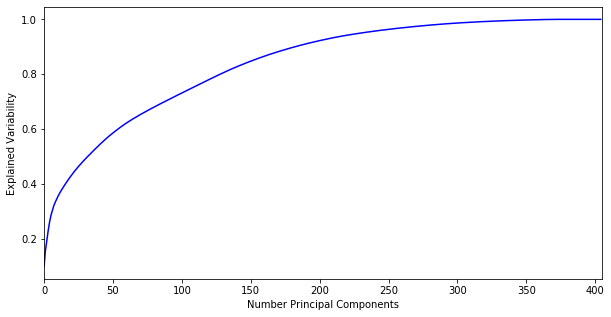

The PCA with 90.0% variance results into keeping 182 features.


In [84]:
azdias_pca, num_pca, pca = learn_principal_components(az_enc, percent=0.9)

By applying PCA to the data 182 features of the 405 are able to describe 90% of the variance. 

In [ ]:
#Plot some numbers about the PCA

In [85]:
top_pc = pca.explained_variance_ratio_[:10]

In [86]:
i = 0
accumulated = 0
for v in top_pc:
    i = i+1
    print('The ',i, 'th compomnent explaines',round(v*100,) ,'% of the variance.')
    accumulated = accumulated +v 
    
print('The accumulated explained variance is ',round(accumulated*100,2),'%.')

The  1 th compomnent explaines 10.0 % of the variance.
The  2 th compomnent explaines 6.0 % of the variance.
The  3 th compomnent explaines 4.0 % of the variance.
The  4 th compomnent explaines 4.0 % of the variance.
The  5 th compomnent explaines 3.0 % of the variance.
The  6 th compomnent explaines 2.0 % of the variance.
The  7 th compomnent explaines 2.0 % of the variance.
The  8 th compomnent explaines 2.0 % of the variance.
The  9 th compomnent explaines 1.0 % of the variance.
The  10 th compomnent explaines 1.0 % of the variance.
The accumulated explained variance is  34.43 %.


 34% of the variance can be explained by the top 10 principal components. 

In [89]:
def get_pca_features(pca, num_comp = 3):
    for c in np.arange(0,num_comp):
        weight = pca.components_[0]
        df_features = pd.DataFrame(weights_array, index = column_names, columns=['weight'])
    return df_features.sort_values(by='weight', ascending=False).round(2)

#### Perfrom PCA on customers dataframe

In [93]:
# Perform the prviously learnd PCA on the customers datapca on the customer dataset
cu_std = StandardScaler().fit_transform(cu_enc)
customers_pca = pca.transform(cu_std)

Now the PCA is completed on both dataframes. To explain 90% of variance 182 principal cpmponents are needed and thereby keept. 
In the following thy will be used to perfrom a clustering on the data. 

### 2.2.Perform Clsutering 

In [94]:
def kmean_clsuter_evaluation(df, cluster_min = 2, cluster_max = 20):
    '''
    INPUT 
    df - pandas dataframe to train k-means on 
    
    OUTPUT
    None
    
    This function display elbow plot for k-mean clustering on dataframe. 
    
    '''
    Sum_of_squared_distances = []
    
    for k in range(cluster_min, cluster_max + 1):
        # run k-means clustering
        k_means = KMeans(n_clusters=k, random_state=0).fit(df)
        # Record sum of squared distances of samples to the nearest cluster center
        Sum_of_squared_distances.append(k_means.inertia_)
        print('-----Computing Cluster No. {} ------'.format(k))
       

    #The elbow method as a first evaluation metic 
    plt.figure(figsize = (10,5))
    plt.plot(range(cluster_min, cluster_max + 1), Sum_of_squared_distances, marker='o', linestyle='--')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Sum of squared distances')
    plt.title('K-Means with PCA Clustering')
    plt.show()
    

-----Computing Cluster No. 2 ------
-----Computing Cluster No. 3 ------
-----Computing Cluster No. 4 ------
-----Computing Cluster No. 5 ------
-----Computing Cluster No. 6 ------
-----Computing Cluster No. 7 ------
-----Computing Cluster No. 8 ------
-----Computing Cluster No. 9 ------
-----Computing Cluster No. 10 ------
-----Computing Cluster No. 11 ------
-----Computing Cluster No. 12 ------
-----Computing Cluster No. 13 ------
-----Computing Cluster No. 14 ------
-----Computing Cluster No. 15 ------
-----Computing Cluster No. 16 ------
-----Computing Cluster No. 17 ------
-----Computing Cluster No. 18 ------
-----Computing Cluster No. 19 ------
-----Computing Cluster No. 20 ------


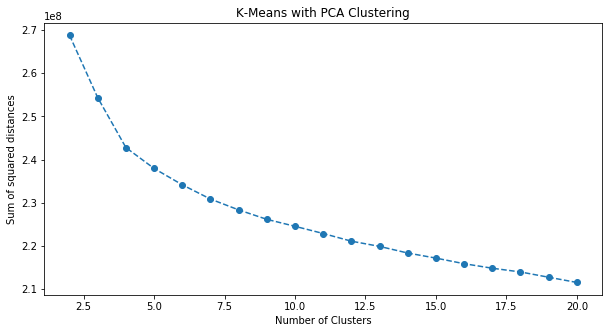

In [95]:
#compute k-means clsutering to find the optimal number of clusters
kmean_clsuter_evaluation(azdias_pca, cluster_max = 20)

Though the ellbow is not very clearly identifiable it shows that the clustering should be done with 12-15 Clsuters
In this case 13 Clsuters seem to be a reasonabale chloice. 

- PCA-Components = 182
- Number of Cluster = 13

In [96]:
# Train & fit K-Means on the azdias dataset with the previously evaluated ideal number of clusters
kmeans = KMeans(n_clusters=13, random_state=42)
km_model = kmeans.fit(azdias_pca)

azdias_cluster = pd.DataFrame(km_model.predict(azdias_pca), columns=['cluster'])

### 2.3 Results interpreation

In [97]:
#prepare a dataframe that provides descriptive inforamtion for each cluster 
customers_cluster = pd.DataFrame(km_model.predict(customers_pca), columns=['cluster'])
azdias_cl_cnt = azdias_cluster['cluster'].value_counts().sort_index()
customers_cl_cnt = customers_cluster['cluster'].value_counts().sort_index()

comb_clusters = pd.concat([azdias_cl_cnt, customers_cl_cnt], axis=1).reset_index()
comb_clusters.columns = ['cluster', 'population_count', 'customers_count']
comb_clusters['cluster'] = comb_clusters.index+1

comb_clusters['population_share'] = comb_clusters['population_count']/comb_clusters['population_count'].sum()*100
comb_clusters['customers_share'] = comb_clusters['customers_count']/comb_clusters['customers_count'].sum()*100
comb_clusters['diff_share'] = comb_clusters['customers_share'] - comb_clusters['population_share']

In [98]:
#short look at the data
comb_clusters

,cluster,population_count,customers_count,population_share,customers_share,diff_share
0,1,16294,4466,1.992728,3.079236,1.086507
1,2,48072,6125,5.879123,4.223089,-1.656033
2,3,53649,8362,6.561180,5.765465,-0.795715
3,4,101646,22617,12.431131,15.594059,3.162929
4,5,32313,4665,3.951824,3.216443,-0.735381
5,6,51648,4522,6.316461,3.117847,-3.198615
6,7,95051,24576,11.624574,16.944759,5.320185
7,8,105447,13406,12.895987,9.243222,-3.652764
8,9,81775,7378,10.000942,5.087013,-4.913929
9,10,13822,2658,1.690407,1.832648,0.142242


In [111]:
#Prepare data so it can be plotted clusterwise in a grouped barplot
population_ratio = comb_clusters[['cluster','population_share']]
population_ratio = population_ratio.rename(columns={'population_share':'value'})
population_ratio.set_index(pd.DataFrame(['Population']*population_ratio.shape[0])[0], inplace = True)

custumer_ratio = comb_clusters[['cluster','customers_share']]
custumer_ratio = custumer_ratio.rename(columns={'customers_share':'value'})
custumer_ratio.set_index(pd.DataFrame(['Customers']*population_ratio.shape[0])[0], inplace = True)

cluster_plt = population_ratio.append(custumer_ratio).reset_index()

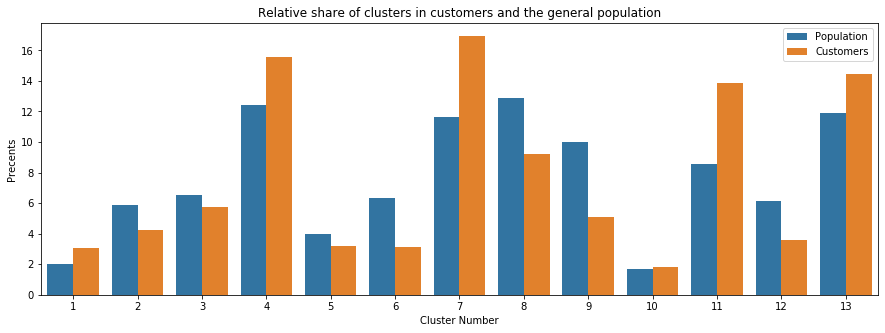

In [112]:
#plot a grouped bar chart of the clsters and their ratio 
plt.figure(figsize=(15, 5))
sns.barplot(x="cluster", y="value", hue=0, data=cluster_plt)
plt.xlabel('Cluster Number')
plt.ylabel('Precents')
plt.title('Relative share of clusters in customers and the general population')
plt.legend()
plt.show()

The plot shows the distribution of the population and the customer data across the 13 selected clsuters. 
It can be seen that the in the cusotomers data the clusters are more uneven.
For the customer data seem to peek in clsuters 3 and 8. For differentiation to the general population let's look at the next figure. 

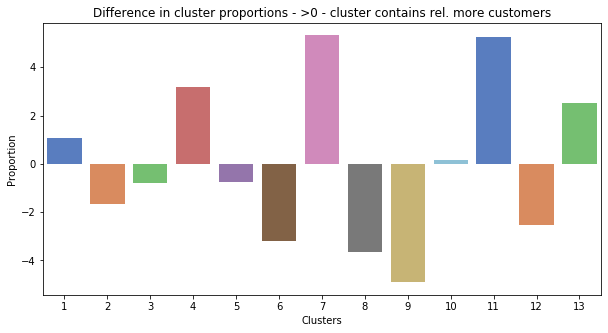

In [113]:
#plot the difference in proportion for the clusters
fig = plt.figure(figsize=(10,5))
ax = sns.barplot(x = comb_clusters['cluster'], y = comb_clusters['diff_share'], palette="muted")
ax.set(title=f'Difference in cluster proportions - >0 - cluster contains rel. more customers', ylabel='Proportion', xlabel='Clusters');

The figure aboves shows the deviation from the customers data from the genreal population. 
It shows that clsuter 8 and 3 are good chices to investigate in order to find out what attributes make a arvato customer. 

Conversly clsuter 9 and 4 apper to be negative exaples. 

#### Investigate the clsuters of intrest 

In [132]:
#select the clusters to select the centers from
customers_center = kmeans.cluster_centers_[7]
azdias_center = kmeans.cluster_centers_[9]

In [133]:
#invert transform the inforamtion for the two slected clusters
center_customers_inv = pca.inverse_transform(customers_center)
center_azidas_inv = pca.inverse_transform(azdias_center)

In [134]:
#retrieve the original cloumn names from the datasets
cu_feature_names = cu_enc.columns
az_feature_names = az_enc.columns

In [135]:
features = pd.DataFrame({"feature" : cu_feature_names, "intrested_cluster_7": center_customers_inv,"not_intrested_cluster_9": center_azidas_inv}) #, 'Difference': (center_customers_inv - center_general_inv)})

In [136]:
features

,feature,intrested_cluster_7,not_intrested_cluster_9
0,AKT_DAT_KL,0.502021,0.000109
1,ALTER_HH,0.102189,-0.051065
2,ALTERSKATEGORIE_FEIN,0.226231,-0.032417
3,ANZ_HAUSHALTE_AKTIV,-0.109898,-0.098682
4,ANZ_HH_TITEL,-0.087268,-0.013235
...,...,...,...
400,D19_LETZTER_KAUF_BRANCHE_D19_VERSICHERUNGEN,-0.083037,-0.017809
401,D19_LETZTER_KAUF_BRANCHE_D19_VOLLSORTIMENT,-0.112915,0.003342
402,D19_LETZTER_KAUF_BRANCHE_D19_WEIN_FEINKOST,-0.038669,-0.001734
403,OST_WEST_KZ_O,-0.388795,-0.105084


In [140]:
#prepare a list to investigate the features that are more likely to be seen in the two selected clsuters
features['Difference'] = features['intrested_cluster_7'] - features['not_intrested_cluster_9']
features.sort_values(by='intrested_cluster_7',ascending = False ,inplace=True)

In [141]:
#plot and investigate cluster of persons which rather tned to become customres from clsuter 8
features.head(50).sort_values(by='intrested_cluster_7').head(20)

,feature,intrested_cluster_7,not_intrested_cluster_9,Difference
224,KBA13_SITZE_4,0.273754,0.240340,0.033414
281,UMFELD_ALT,0.276421,-0.151986,0.428407
161,KBA13_HALTER_50,0.279136,0.014973,0.264163
203,KBA13_MERCEDES,0.287683,0.221446,0.066236
68,KBA05_DIESEL,0.292025,0.105970,0.186055
52,HH_EINKOMMEN_SCORE,0.296873,0.226161,0.070711
120,KBA13_ALTERHALTER_60,0.301876,0.042956,0.258920
209,KBA13_SEG_GELAENDEWAGEN,0.302750,0.127743,0.175006
27,D19_VERSAND_DATUM,0.303139,0.040985,0.262155
66,KBA05_CCM3,0.303952,0.186820,0.117132


Looking at features where the difference for customers it can be seen that peeople who are customers are rather wealthy.
They are e.g. interested in investment. Living in the city center. And show a propensity to consume. 

In [ ]:
#plot and investigate features that are more likely to be seen in cluster 9
features.tail(20).sort_values(by='not_intrested_cluster_9').head(20)

Conversly, people with rather limited financial wealth are more unlikely to become customers. 

## Part 2: Supervised Learning Model

Now that you've found which parts of the population are more likely to be customers of the mail-order company, it's time to build a prediction model. Each of the rows in the "MAILOUT" data files represents an individual that was targeted for a mailout campaign. Ideally, we should be able to use the demographic information from each individual to decide whether or not it will be worth it to include that person in the campaign.

The "MAILOUT" data has been split into two approximately equal parts, each with almost 43 000 data rows. In this part, you can verify your model with the "TRAIN" partition, which includes a column, "RESPONSE", that states whether or not a person became a customer of the company following the campaign. In the next part, you'll need to create predictions on the "TEST" partition, where the "RESPONSE" column has been withheld.

## 2.1 Load and investigate training data

In [143]:
#Load and clean the dataset
mailout_train = data_load_and_prep('data/Udacity_MAILOUT_052018_TRAIN.csv')

Column  CUSTOMER_GROUP  was not in the df.
Column  ONLINE_PURCHASE  was not in the df.
Column  PRODUCT_GROUP  was not in the df.
LNR Column is droped from the data.
===============Changing the Unkown Data to NaNs======================
============Remiving Columns and Rows with to many NaNs==============
---------Remove columns with more than 50% missings------------
The shape of the old dataframe: (42962, 366)
The shape of the new dataframe: (42962, 312)
54 columns have been removed from the dataframe.
----------------------------------------------------------------
---------Remove rows with more than 80% missings------------
The shape of the old dataframe: (42962, 312)
The shape of the new dataframe: (35990, 312)
6972 rows have been removed from the dataframe.
====================Data Imputation================================
Col D19_BANKEN_DATUM no in the df anymore.
Col D19_BANKEN_OFFLINE_DATUM no in the df anymore.
Col D19_BANKEN_ONLINE_DATUM no in the df anymore.
Col D19_TELKO_DA

In [144]:
# Make 'RESPONSE' the y variable 
mailout_y = mailout_train['RESPONSE']
mailout_X = mailout_train.drop('RESPONSE',axis = 1)

In [145]:
#checking the number of rows for both datasets

In [511]:
mailout_X.shape[0]

35990

In [147]:
mailout_y.shape[0]

35990

Text(0.5, 1.0, 'Distribution of customer response')

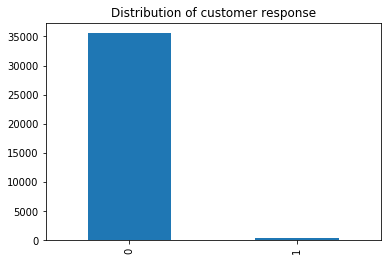

In [148]:
# Checking the distribution for the target
mailout_y.value_counts().plot.bar() 
plt.title('Distribution of customer response')

In [514]:
mailout_y.value_counts()

0    35541
1      449
Name: RESPONSE, dtype: int64

In [149]:
print('The training data shows a response rate of ',round(mailout_y.value_counts()[1] / mailout_train.shape[0] * 100, 2),'%. ')

The training data shows a response rate of  1.25 %. 


#### Build ML-Pipeline to thest diffrent models

In [150]:
def predict_learning_curves(X, y, model):
    """
    Predict model using learning curves and plots the curces on trainig and coss-validation data. 
    
    
    Input:
        df (X) - array-like of shape  that holds the features th fit the model on 
        Series (y): array like shape that holds tha target value
        model: object type that implements the “fit” and “predict” methods
        num_trainings (int): number of training samples to plot
        
    """
    
    train_sizes, train_scores, test_scores = learning_curve(model, X, y, scoring = 'roc_auc',train_sizes=np.linspace(.1, 1.0, 10))

    train_scores_mean = np.mean(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    print("AUC train score = {}".format(round(train_scores_mean[-1],2)))
    print("AUC validation score = {}".format(round(test_scores_mean[-1],2)))
    plt.grid()
    
    #Plottin the learning- curves 
    plt.title("Learning Curve")
    plt.xlabel("% of training set")
    plt.ylabel("Score")

    plt.plot(np.linspace(.2, 1.0, 10)*100, train_scores_mean, color="b",label="Score on training data")
    plt.plot(np.linspace(.2, 1.0, 10)*100, test_scores_mean, color="r", label="Score on cross-validation sets")

    plt.yticks(np.arange(0.45, 1.02, 0.05))
    plt.xticks(np.arange(0., 100.05, 10))
    plt.legend(loc="best")
    plt.show()

## 2.2 Build ML-Pipeline to thest diffrent algorithms

In [151]:
models = {
          'RandomForestClassifier': RandomForestClassifier(), 
          'GradientBoostingClassifier': GradientBoostingClassifier(),
          'XGBClassifier': xgb.XGBClassifier()
         }

RandomForestClassifier
AUC train score = 1.0
AUC validation score = 0.59


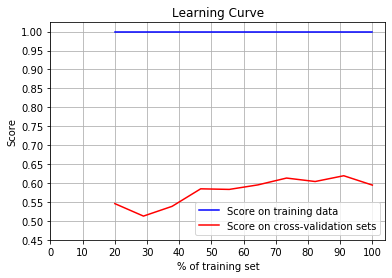

GradientBoostingClassifier
AUC train score = 0.95
AUC validation score = 0.77


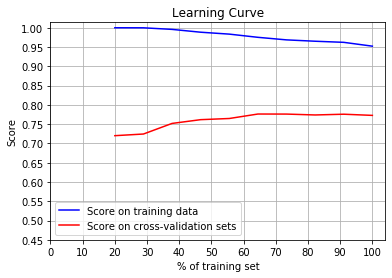

XGBClassifier
AUC train score = 0.93
AUC validation score = 0.77


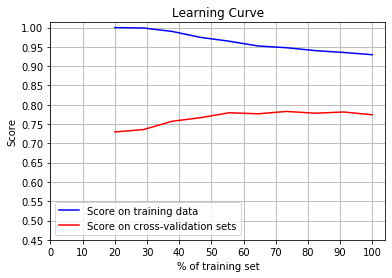

In [152]:
for model_key in models.keys():
    print(model_key)
    ml_pipeline = Pipeline([
        
        ('model', models[model_key])
    ])
    predict_learning_curves(mailout_X, mailout_y, ml_pipeline)

The GBT and XGBT seem to perform the best. Therefore in the next steps the XGBT is used to make the final rediction. 
Furthermore Oversampling is used to counteract the overfitting.

## 2.3 Optimize selected model

### Making a prediction without parameter tuning but with oversampling

Oversampling is used instead of undersampling because the target one class is very rare in total numbers. Using undersampling would increase the threat of dropping to much relevant inforamtion from the target zero class. 

In [487]:
oversampler = SMOTE(sampling_strategy = 0.33)
X_train_os, y_train_os = oversampler.fit_resample(mailout_X, mailout_y)

In [488]:
nomral_model, model1_roc = XGB_Classify(X_train_os,y_train_os, 5)

XGBClassifier(max_depth=5, verbosity=0)
ROC score: 0.9223226466575716
Accuracy: 95.60% (1.24%)


The XGB Boost did quite good job on the Kagge challenge with a score of 0.6 AUC and place 199 in the leaderboard. 

### Using GridSearch to imporve the model without oversampling

In [212]:
X = mailout_X
y = mailout_y

In [214]:
#initialize with GradientBoostingClassifier
xgb_pipeline = Pipeline([
    ('xgb', GradientBoostingClassifier(random_state=42))
])

parameters = {'xgb__learning_rate': [0.1, 0.2], 'xgb__n_estimators': [100],
             'xgb__max_depth': [3, 5], 'xgb__min_samples_split': [2,4]}        
        
grid_obj = GridSearchCV(gbc_pipeline, parameters, scoring = 'roc_auc', verbose=50)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100, score=0.750, total=  32.6s
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   32.6s remaining:    0.0s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100, score=0.746, total=  32.7s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  1.1min remaining:    0.0s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100, score=0.820, total=  33.1s
[Parallel(n_jobs=1)]: Done   3 out of  

GridSearchCV(estimator=Pipeline(steps=[('xgb',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'xgb__learning_rate': [0.1, 0.2],
                         'xgb__max_depth': [3, 5],
                         'xgb__min_samples_split': [2, 4],
                         'xgb__n_estimators': [100]},
             scoring='roc_auc', verbose=50)

In [215]:
# Taking the evaluetd estimator to predict 
print(grid_obj.best_params_)
best_clf = grid_obj.best_estimator_
best_predictions = best_clf.predict_proba(X)[:,1]

# Doin the prediction on the train dataset with optimized parameters
predictions = (xgb_pipeline.fit(X, y)).predict_proba(X)[:,1]

print("ROC score: {:.4f}".format(roc_auc_score(y, predictions)))
print("Final ROC score: {:.4f}".format(roc_auc_score(y, best_predictions)))



{'xgb__learning_rate': 0.1, 'xgb__max_depth': 3, 'xgb__min_samples_split': 4, 'xgb__n_estimators': 100}
ROC score: 0.9361
Final ROC score: 0.9378


This makes quite an improvement to letting the model run withot parameter tuning where it ran into overfitting. (
It also outperformes the "naive" XGB model that uses oversampling by a great margin. The old version on rebalacned data

In [486]:
# store file in the WD
filename = "unbalanced_xgb_model.pkl"  
with open(filename, 'wb') as file:  
    pickle.dump(best_clf, file)

### Using GridSearch to imporve the model without oversampling

In [489]:
X = X_train_os
y = y_train_os

In [490]:
#initialize with GradientBoostingClassifier
xgb_pipeline = Pipeline([
    ('xgb', GradientBoostingClassifier(random_state=42))
])

parameters = {'xgb__learning_rate': [0.1, 0.2], 'xgb__n_estimators': [100],
             'xgb__max_depth': [3, 5], 'xgb__min_samples_split': [2,4]}        
        
grid_obj = GridSearchCV(gbc_pipeline, parameters, scoring = 'roc_auc', verbose=50)

# Fit the grid search object to the training data and find the optimal parameters
grid_obj.fit(X, y)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100, score=0.965, total= 1.3min
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.3min remaining:    0.0s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100, score=1.000, total= 1.2min
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  2.5min remaining:    0.0s
[CV] xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100 
[CV]  xgb__learning_rate=0.1, xgb__max_depth=3, xgb__min_samples_split=2, xgb__n_estimators=100, score=1.000, total= 1.3min
[Parallel(n_jobs=1)]: Done   3 out of  

GridSearchCV(estimator=Pipeline(steps=[('xgb',
                                        GradientBoostingClassifier(random_state=42))]),
             param_grid={'xgb__learning_rate': [0.1, 0.2],
                         'xgb__max_depth': [3, 5],
                         'xgb__min_samples_split': [2, 4],
                         'xgb__n_estimators': [100]},
             scoring='roc_auc', verbose=50)

In [491]:
# Taking the evaluetd estimator to predict 
print(grid_obj.best_params_)
best_clf = grid_obj.best_estimator_
best_predictions = best_clf.predict_proba(X)[:,1]

# Doin the prediction on the train dataset with optimized parameters
predictions = (xgb_pipeline.fit(X, y)).predict_proba(X)[:,1]

print("ROC score: {:.4f}".format(roc_auc_score(y, predictions)))
print("Final ROC score: {:.4f}".format(roc_auc_score(y, best_predictions)))



{'xgb__learning_rate': 0.1, 'xgb__max_depth': 5, 'xgb__min_samples_split': 4, 'xgb__n_estimators': 100}
ROC score: 0.9944
Final ROC score: 0.9990


Even tough the high ROC-Score comes from the diffrent distribution of the training sets this model scores best in the Kaggle challenge with a AUC score of 0.77130 wich is an improvment of 0.02848 points. 

In [495]:
# store file in the WD
filename = "oversampling_xgb_model.pkl"  
with open(filename, 'wb') as file:  
    pickle.dump(best_clf, file)

## Part 3: Kaggle Competition

Now that you've created a model to predict which individuals are most likely to respond to a mailout campaign, it's time to test that model in competition through Kaggle. If you click on the link [here](http://www.kaggle.com/t/21e6d45d4c574c7fa2d868f0e8c83140), you'll be taken to the competition page where, if you have a Kaggle account, you can enter. If you're one of the top performers, you may have the chance to be contacted by a hiring manager from Arvato or Bertelsmann for an interview!

Your entry to the competition should be a CSV file with two columns. The first column should be a copy of "LNR", which acts as an ID number for each individual in the "TEST" partition. The second column, "RESPONSE", should be some measure of how likely each individual became a customer – this might not be a straightforward probability. As you should have found in Part 2, there is a large output class imbalance, where most individuals did not respond to the mailout. Thus, predicting individual classes and using accuracy does not seem to be an appropriate performance evaluation method. Instead, the competition will be using AUC to evaluate performance. The exact values of the "RESPONSE" column do not matter as much: only that the higher values try to capture as many of the actual customers as possible, early in the ROC curve sweep.

### 3.1 Score data

In [496]:
#loading the score data with score_mode = True so that no rows will be deleted in the preprocessing
Scoring_Data = data_load_and_prep('data/Udacity_MAILOUT_052018_TEST.csv', score_mode = True)

Column  CUSTOMER_GROUP  was not in the df.
Column  ONLINE_PURCHASE  was not in the df.
Column  PRODUCT_GROUP  was not in the df.
LNR is keept for scoring
===============Changing the Unkown Data to NaNs======================
============Remiving Columns and Rows with to many NaNs==============
---------Remove columns with more than 50% missings------------
The shape of the old dataframe: (42833, 366)
The shape of the new dataframe: (42833, 312)
54 columns have been removed from the dataframe.
----------------------------------------------------------------
---------Remove rows with more than 100% missings------------
The shape of the old dataframe: (42833, 312)
The shape of the new dataframe: (42833, 312)
0 rows have been removed from the dataframe.
====================Data Imputation================================
Col D19_BANKEN_DATUM no in the df anymore.
Col D19_BANKEN_OFFLINE_DATUM no in the df anymore.
Col D19_BANKEN_ONLINE_DATUM no in the df anymore.
Col D19_TELKO_DATUM no in the

In [497]:
# Extract LNR from the data and store into variable
lnr = Scoring_Data['LNR']
X_test = Scoring_Data.drop(['LNR'],axis = 1)

In [498]:
#apply the trained model to the test data 
y_test_est = best_clf.predict_proba(X_test)

In [499]:
y_est = pd.Series(y_test_est[:,1])

In [500]:
result = pd.DataFrame(data = [lnr,y_est]).T
result

,LNR,Unnamed 0
0,1754.0,0.041133
1,1770.0,0.022301
2,1465.0,0.005921
3,1470.0,0.006973
4,1478.0,0.004128
...,...,...
42828,67615.0,0.015223
42829,67938.0,0.002410
42830,67942.0,0.027315
42831,67949.0,0.054999


In [501]:
result = result.rename(columns={'Unnamed 0':'RESPONSE'})

In [502]:
result['LNR'] = result['LNR'].astype(int)

In [503]:
result.dtypes

LNR           int64
RESPONSE    float64
dtype: object

### 3.2 Export data to csv for Kaggle

In [504]:
result.to_csv('predict_test.csv', index=False, sep=',', encoding='utf-8')

Finally save notebook to HTML

In [516]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Arvato_Project_Workbook.ipynb'])

0